## ✅ 목표 요약

- 전처리된 `mapo_restaurants.csv` 불러오기
- `위도`, `경도` 데이터를 기반으로 클러스터링 수행
- 각 음식점에 클러스터 라벨 부여

## 📦 1. 라이브러리 불러오기 & 데이터 로드

In [66]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("../data/processed/mapo_restaurants.csv")

# 확인
df.head()

,사업장명,지번주소,위도,경도
0,해적쭈꾸미,서울특별시 마포구 망원동 394-89번지 1층,37.552936,126.903311
1,보물섬,서울특별시 마포구 아현동 326-24번지,37.555927,126.951907
2,굴다리식당,"서울특별시 마포구 도화동 25-6번지 ,7",37.542255,126.948966
3,우리왕만두,서울특별시 마포구 대흥동 404-6번지,37.546144,126.938931
4,홀짝홀짝,서울특별시 마포구 서교동 355-25,37.553685,126.918553


## 📊 2. 클러스터링 수행 (KMeans)

In [67]:
# 좌표 데이터만 추출
coords = df[["위도", "경도"]]

# Kmeans 클러스터링
k = 5  # 클러스터 개수
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(coords)

# 결과 확인
df.head()

,사업장명,지번주소,위도,경도,cluster
0,해적쭈꾸미,서울특별시 마포구 망원동 394-89번지 1층,37.552936,126.903311,3
1,보물섬,서울특별시 마포구 아현동 326-24번지,37.555927,126.951907,1
2,굴다리식당,"서울특별시 마포구 도화동 25-6번지 ,7",37.542255,126.948966,1
3,우리왕만두,서울특별시 마포구 대흥동 404-6번지,37.546144,126.938931,1
4,홀짝홀짝,서울특별시 마포구 서교동 355-25,37.553685,126.918553,0


## 🧼 3. 클러스터링 결과 시각화 (산점도)

In [68]:
#!rm -rf ~/.cache/matplotlib

In [69]:
import matplotlib.font_manager as fm
import platform

# 한글 폰트 설정 (운영체체 별)
if platform.system() == "Windows":
    plt.rc("font", family="Malgun Gothic")
elif platform.system() == "Darwin":
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="NanumGothic")

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

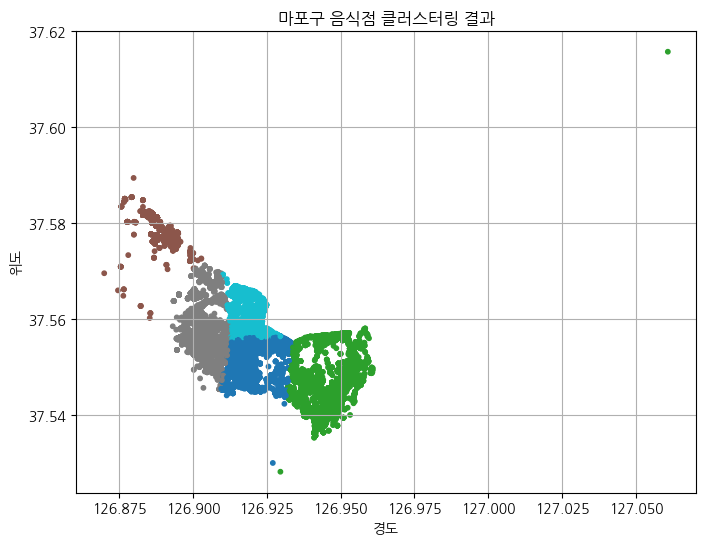

In [70]:
plt.figure(figsize=(8, 6))
plt.scatter(df["경도"], df["위도"], c=df["cluster"], cmap="tab10", s=10)
plt.title("마포구 음식점 클러스터링 결과")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(True)
plt.show()

## 💾 4. 클러스터링 결과 저장 (지도에서 활용 예정)

In [71]:
df.to_csv("../data/processed/mapo_restaurants_clustered.csv", index=False)

## 🎯 최적 클러스터 개수 찾기 (Elbow Method)

In [72]:
coords = df[["위도", "경도"]]

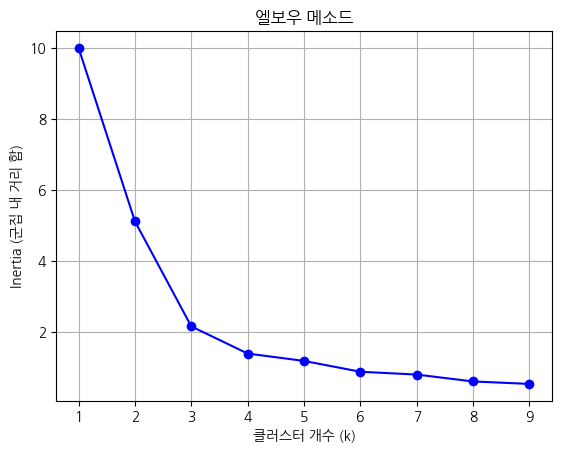

In [73]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(1, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(coords)
    inertias.append(model.inertia_)

plt.plot(K, inertias, "bo-")
plt.xlabel("클러스터 개수 (k)")
plt.ylabel("Inertia (군집 내 거리 합)")
plt.title("엘보우 메소드")
plt.grid(True)
plt.show()

## 📘 시각화 코드 (최적 k 찾기용) - Silhouette Score

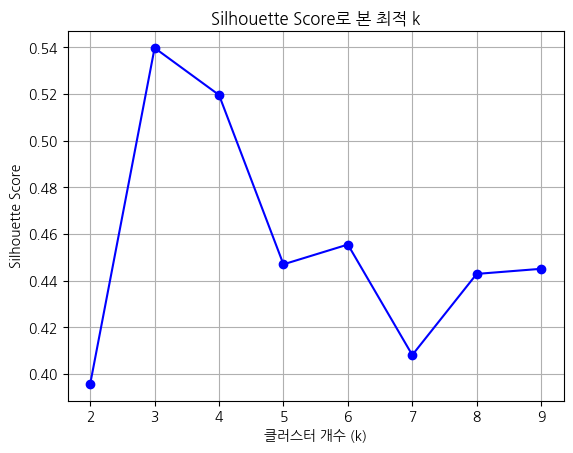

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
K = range(2, 10)  # 최소 2부터 시작해야 silhouette score 계산 가능

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(coords)
    score = silhouette_score(coords, labels)
    silhouette_scores.append(score)

# 시각화
plt.plot(K, silhouette_scores, "bo-")
plt.xlabel("클러스터 개수 (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score로 본 최적 k")
plt.grid(True)
plt.show()

## ✅ 1. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

### 📌 특징
- 밀도 기반 클러스터링 알고리즘
- **이웃이 많은 지점을 중심으로 클러스터 형성**
- **클러스터 수 자동 결정**
- **노이즈(군집에 속하지 않는 점)**도 자동 감지함

In [77]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# 좌표를 표준화 (경도/위도는 거리 단위가 달라서 꼭 필요)
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df[["위도", "경도"]])

# DBSCAN 모델 정의
dbscan = DBSCAN(eps=0.05, min_samples=5)  # eps: 반경, min_samples: 최소 이웃 수
df["dbscan_cluster"] = dbscan.fit_predict(coords_scaled)

# 클러스터 개수 확인 (-1은 노이즈)
print(df["dbscan_cluster"].value_counts())

dbscan_cluster
0      16673
2       2065
3       1771
20       739
1        471
       ...  
112        5
85         5
114        5
4          5
82         5
Name: count, Length: 136, dtype: int64


<Axes: title={'center': '상위 10개 클러스터'}, xlabel='dbscan_cluster'>

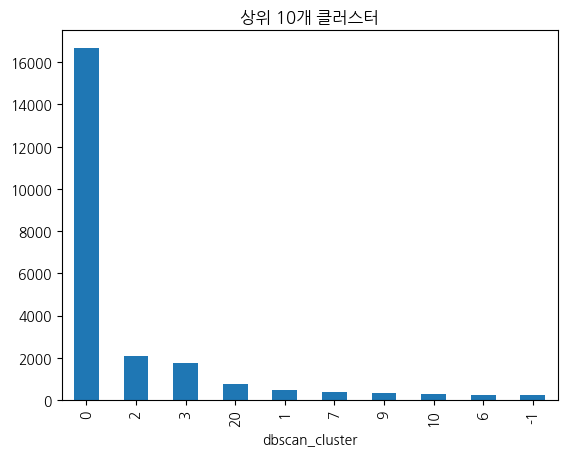

In [78]:
df["dbscan_cluster"].value_counts().head(10).plot(
    kind="bar", title="상위 10개 클러스터"
)

## ✅ 2. Mean Shift

### 📌 특징
- 데이터의 **확률 밀도가 높은 영역 중심**으로 점들을 이동시키며 클러스터링
- **자동으로 군집 수 결정**
- KMeans보다 연산량은 많지만, 군집 수 지정 없이 부드럽게 클러스터링 가능

In [75]:
from sklearn.cluster import MeanShift

# MeanShift는 거리 기준으로 자동 군집화
meanshift = MeanShift()
df["meanshift_cluster"] = meanshift.fit_predict(coords)

# 군집 수 확인
print(df["meanshift_cluster"].value_counts())

meanshift_cluster
0    16751
1     7280
2     2684
3        1
Name: count, dtype: int64


## ✅ 결론: **k = 3이 가장 적절한 클러스터 수**

- **Silhouette Score** 기준에서 가장 높은 값을 기록
- 이는 **데이터가 세 개의 명확한 그룹**으로 나뉜다는 강력한 근거입니다
- Elbow Method에서도 `k=3`에서 큰 꺾임이 있었으므로, **두 방법이 일치**하는 결과예요 → ✔️ 매우 신뢰할 수 있음

## ✅ 1. 클러스터 재실행 (`k = 3`)

In [65]:
from sklearn.cluster import KMeans

# 위치 데이터만 사용
coords = df[["위도", "경도"]]

# 클러스터링 수행 (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(coords)

# 결과 저장 (선택)
df.to_csv("../data/processed/mapo_restaurants_clustered_k3.csv", index=False)

## 📊 2. 각 클러스터별 요약 통계

### ✔️ 클러스터별 음식점 수

In [51]:
cluster_counts = df["cluster"].value_counts().sort_index()
print("클러스터별 음식점 수:\n", cluster_counts)

클러스터별 음식점 수:
 cluster
0    15106
1     6982
2     4628
Name: count, dtype: int64


### ✔️ 클러스터별 중심 좌표 출력

In [52]:
# 중심 좌표 확인
centers = kmeans.cluster_centers_
for i, (lat, lon) in enumerate(centers):
    print(f"클러스터 {i}: 위도={lat:.5f}, 경도={lon:.5f}")

클러스터 0: 위도=37.55413, 경도=126.91843
클러스터 1: 위도=37.54670, 경도=126.94461
클러스터 2: 위도=37.56752, 경도=126.89694


### ✔️ 각 클러스터에서 대표 음식점 3개씩 확인

In [53]:
for i in range(3):
    print(f"\n[클러스터 {i} 대표 음식점]")
    display(df[df["cluster"] == i][["사업장명", "지번주소"]].head(3))


[클러스터 0 대표 음식점]


,사업장명,지번주소
0,해적쭈꾸미,서울특별시 마포구 망원동 394-89번지 1층
4,홀짝홀짝,서울특별시 마포구 서교동 355-25
6,자매분식,서울특별시 마포구 신수동 101-15번지



[클러스터 1 대표 음식점]


,사업장명,지번주소
1,보물섬,서울특별시 마포구 아현동 326-24번지
2,굴다리식당,"서울특별시 마포구 도화동 25-6번지 ,7"
3,우리왕만두,서울특별시 마포구 대흥동 404-6번지



[클러스터 2 대표 음식점]


,사업장명,지번주소
5,이모네포장마차,서울특별시 마포구 망원동 419-3번지 3동 6호
19,낙지촌,서울특별시 마포구 망원동 485-38번지 1층
20,부산어묵,서울특별시 마포구 망원동 411-22번지 1층


## 📍 선택: 클러스터별 중심 좌표를 지도에 표시하고 싶다면

In [54]:
import folium

# 지도 초기화
m = folium.Map(location=[coords["위도"].mean(), coords["경도"].mean()], zoom_start=14)

# 음식점 마커
colors = ["red", "blue", "green"]
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["위도"], row["경도"]],
        radius=3,
        color=colors[row["cluster"]],
        fill=True,
        fill_opacity=0.6,
        popup=row["사업장명"],
    ).add_to(m)

# 중심점 마커
for i, (lat, lon) in enumerate(centers):
    folium.Marker(
        location=[lat, lon],
        popup=f"클러스터 {i} 중심",
        icon=folium.Icon(color=colors[i], icon="info-sign"),
    ).add_to(m)

# 저장
m.save("../outputs/mapo_clusters_k3_with_centers.html")

## 🎉 결과적으로 얻는 것

- 클러스터 3개 중 어떤 지역이 상권 중심인지 알 수 있음
- 향후 상권 유형 분석, 입지 추천 등으로 확장 가능